In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from google.colab import drive
import os

In [1]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print('Device:',device)
device = 'cpu'

In [ ]:
drive.mount("/content/gdrive")

model_save = '/content/gdrive/My Drive/Colab Notebooks/Deep Learning project/model/'
prediction_save = '/content/gdrive/My Drive/Colab Notebooks/Deep Learning project/prediction/'
def maybe_mkdir(path):

  if os.path.exists(path): # checking to see if a folder with name already exists at that location
    print("Directory exists moving on ...")
  else:
    model_save = os.mkdir(path) # Creating a folder to save our model in
    print('Created directory')


# maybe_mkdir(prediction_save)
maybe_mkdir(model_save)


DATA_DIR = '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning project/hippocampus'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Directory exists moving on ...


# Inspect dataset

(131, 98, 84)
(131, 98)


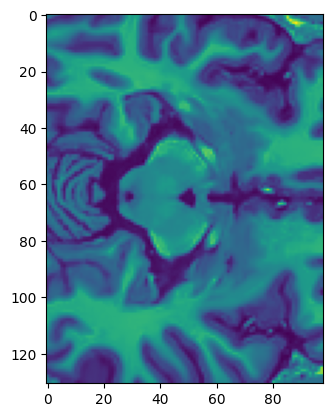

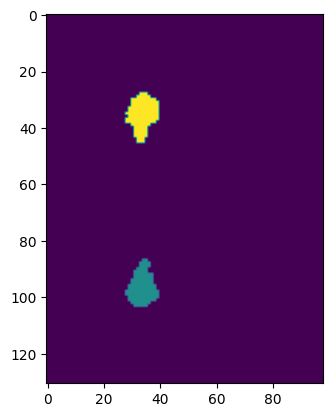

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

#Look at the size of 3 differens images/masks
#img_path = '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning project/hippocampus/nifti/ADNI.021_S_0753.15T.AD_crop_nyul2f.nii'
#img_path = '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning project/hippocampus/nifti/labels/0001_20131002_152839.nii'
img_path = DATA_DIR + '/nifti/0001_20131002_152839.nii'
labels_path = DATA_DIR+ '/nifti/labels/0001_20131002_152839.nii'
test_load = nib.load(img_path).get_fdata()
labels_load = nib.load(labels_path).get_fdata()
print(test_load.shape)
#Same size for all 3

test = test_load[:,:,43]
print(test.shape)
plt.imshow(test)
plt.show()

plt.imshow(labels_load[:,:,43])
plt.show()

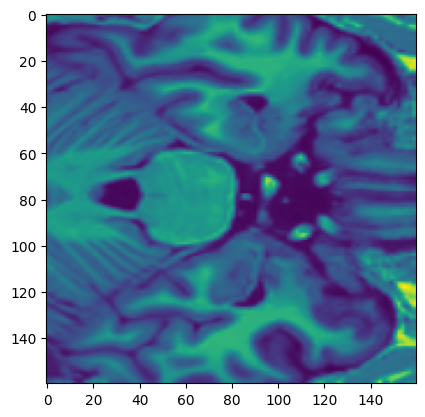

In [ ]:
#Resize image
import skimage.transform as skTrans
im = nib.load(img_path).get_fdata()
result1 = skTrans.resize(im, (160,160,130), order=1, preserve_range=True)

plt.imshow(result1[:,:,43])
plt.show()

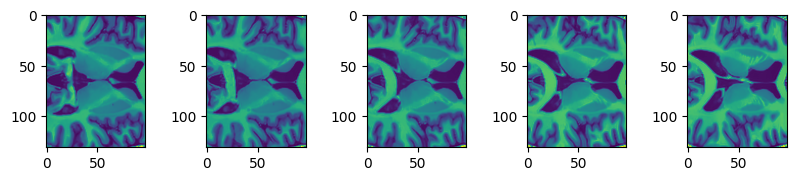

In [ ]:
#Plot 25 slices to see if the size of hippocampus:
for i in range (5):
    plt.subplot(5,5,i+1)
    plt.imshow(test_load[:,:,59+i*2])
    plt.gcf().set_size_inches(10, 10)
plt.show()

# Create dataset

In [2]:
import os
import csv

#Only get the files in the directory
def get_files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield file

In [ ]:
img_path = DATA_DIR + '/nifti'
img_files = list(get_files(img_path))
img_files.sort()

#img_train = img_files[:70]
img_train = img_files[0:4] #Temp for testing

img_val = img_files[70:82]
img_test = img_files[82:]
print(len(img_files))

mask_path = DATA_DIR + '/nifti/labels'
mask_files = os.listdir(mask_path)
mask_files.sort()

mask_train = mask_files[:70]
mask_val = mask_files[70:82]
mask_test = mask_files[82:]
print(len(mask_files))

96
96


In [ ]:
#Train set
image_folder_path = DATA_DIR + "/nifti/"
mask_folder_path = DATA_DIR + "/nifti/labels/"

train_set_path = DATA_DIR + "/data_splits/train_set.csv"
with open(train_set_path , 'w', newline='') as file:
   writer = csv.writer(file)
   writer.writerow(['Image_path', 'Mask_path']) #Header
   for i in range(len(img_train)):
      image_path = os.path.join(image_folder_path, img_train[i]) #Path to the folder containing the images
      mask_path = os.path.join(mask_folder_path, mask_train[i]) #Path to the folder containing the masks
      writer.writerow([image_path, mask_path])



#Validation set
image_folder_path = DATA_DIR + "/nifti/"
mask_folder_path = DATA_DIR + "/nifti/labels/"

val_set_path = DATA_DIR + "/data_splits/val_set.csv"
with open(val_set_path , 'w', newline='') as file:
   writer = csv.writer(file)
   writer.writerow(['Image_path', 'Mask_path']) #Header
   for i in range(len(img_val)):
      image_path = os.path.join(image_folder_path, img_val[i]) #Path to the folder containing the images
      mask_path = os.path.join(mask_folder_path, mask_val[i]) #Path to the folder containing the masks
      writer.writerow([image_path, mask_path])



#Test set
image_folder_path = DATA_DIR + "/nifti/"
mask_folder_path = DATA_DIR + "/nifti/labels/"

test_set_path = DATA_DIR + "/data_splits/test_set.csv"
with open(test_set_path , 'w', newline='') as file:
   writer = csv.writer(file)
   writer.writerow(['Image_path', 'Mask_path']) #Header
   for i in range(len(img_test)):
      image_path = os.path.join(image_folder_path, img_test[i]) #Path to the folder containing the images
      mask_path = os.path.join(mask_folder_path, mask_test[i]) #Path to the folder containing the masks
      writer.writerow([image_path, mask_path])



print('')
print('Data splits are saved!')
print('')


Data splits are saved!



# Create model

In [ ]:
#Load packages
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import nibabel as nib
from torchvision import transforms
from torchvision import models
from torch.nn.functional import relu
from torch.utils.data import Dataset, DataLoader
import matplotlib.image as mpimg
import nibabel.processing
import skimage.transform as skTrans
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv3d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3

        # Our input:
        self.e11 = nn.Conv3d(1, 64, kernel_size=(3,3,3), padding=1) #
        self.e12 = nn.Conv3d(64, 64, kernel_size=(3,3,3), padding=1) #
        self.pool1 = nn.MaxPool3d(kernel_size=(2,2,2), stride=2) #

        # input: 64x47x41
        self.e21 = nn.Conv3d(64, 128, kernel_size=(3,3,3), padding=1) #
        self.e22 = nn.Conv3d(128, 128, kernel_size=(3,3,3), padding=1) #
        self.pool2 = nn.MaxPool3d(kernel_size=(2,2,2), stride=2) #

        # input: 30x22x18
        self.e31 = nn.Conv3d(128, 256, kernel_size=(3,3,3), padding=1) #
        self.e32 = nn.Conv3d(256, 256, kernel_size=(3,3,3), padding=1) #
        self.pool3 = nn.MaxPool3d(kernel_size=(2,2,2), stride=2) #

        # input: 26x18x14
        self.e41 = nn.Conv3d(256, 512, kernel_size=(3,3,3), padding=1) #
        self.e42 = nn.Conv3d(512, 512, kernel_size=(3,3,3), padding=1) #
        self.pool4 = nn.MaxPool3d(kernel_size=(2,2,2), stride=2) #

        # input: 22x14x10
        self.e51 = nn.Conv3d(512, 1024, kernel_size=(3,3,3), padding=1) #
        self.e52 = nn.Conv3d(1024, 1024, kernel_size=(3,3,3), padding=1) #


        # Decoder
        self.upconv1 = nn.ConvTranspose3d(1024, 512, kernel_size=(2,2,2), stride=2) #
        self.d11 = nn.Conv3d(1024, 512, kernel_size=(3,3,3), padding=1) #
        self.d12 = nn.Conv3d(512, 512, kernel_size=(3,3,3), padding=1) #

        self.upconv2 = nn.ConvTranspose3d(512, 256, kernel_size=(2,2,2), stride=2) #
        self.d21 = nn.Conv3d(512, 256, kernel_size=(3,3,3), padding=1)
        self.d22 = nn.Conv3d(256, 256, kernel_size=(3,3,3), padding=1)

        self.upconv3 = nn.ConvTranspose3d(256, 128, kernel_size=(2,2,2), stride=2)
        self.d31 = nn.Conv3d(256, 128, kernel_size=(3,3,3), padding=1)
        self.d32 = nn.Conv3d(128, 128, kernel_size=(3,3,3), padding=1)

        self.upconv4 = nn.ConvTranspose3d(128, 64, kernel_size=(2,2,2), stride=2)
        self.d41 = nn.Conv3d(128, 64, kernel_size=(3,3,3), padding=1)
        self.d42 = nn.Conv3d(64, 64, kernel_size=(3,3,3), padding=1)

        # Output layer
        self.outconv = nn.Conv3d(64, n_class, kernel_size=(1,1,1))
        #self.soft =nn.Softmax(dim=0)


    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        print(xu1.shape)
        print(xe42.shape)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        print('')

        xu2 = self.upconv2(xd12)
        print(xu2.shape)
        print(xe32.shape)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        print('')

        xu3 = self.upconv3(xd22)
        print(xu3.shape)
        print(xe22.shape)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        print('')

        xu4 = self.upconv4(xd32)
        print(xu4.shape)
        print(xe12.shape)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)
        #out = self.soft(out)

        return out

In [ ]:
class CustomDataset(Dataset):
    def __init__(self):
        traindf = pd.read_csv(DATA_DIR + "/data_splits/train_set.csv",
                      sep= ",",
                      dtype=str)

        self.data = []
        for i in range(len(traindf)):
            self.data.append([traindf["Image_path"][i],
                            traindf["Mask_path"][i]])

        self.img_dim = (128, 128, 128)
        #self.img_dim = (572, 572, 572)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, mask_path = self.data[idx]
        img = nib.load(img_path).get_fdata()
        img = skTrans.resize(img, self.img_dim, order=1, preserve_range=True)

        mask = nib.load(mask_path).get_fdata()
        mask = skTrans.resize(img, self.img_dim, order=1, preserve_range=True)

        img_tensor = torch.from_numpy(img).float()
        #img_tensor = img_tensor.permute(2, 0, 1) # PyTorch = Channels first -> channels × rows × columns
        img_tensor = img_tensor.unsqueeze(0) #Add sample dim -> sample × channels × rows × columns
        #print(img_tensor.shape)

        mask_tensor = torch.from_numpy(mask).float()
        #mask_tensor = mask_tensor.permute(2, 0, 1)
        mask_tensor = mask_tensor.unsqueeze(0)

        return img_tensor, mask_tensor

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=0):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)
        target = F.sigmoid(targets)
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

______________________________________________
Started Training
torch.Size([2, 512, 16, 16, 16])
torch.Size([2, 512, 16, 16, 16])

torch.Size([2, 256, 32, 32, 32])
torch.Size([2, 256, 32, 32, 32])

torch.Size([2, 128, 64, 64, 64])
torch.Size([2, 128, 64, 64, 64])

torch.Size([2, 64, 128, 128, 128])
torch.Size([2, 64, 128, 128, 128])
Loss: 0.1227


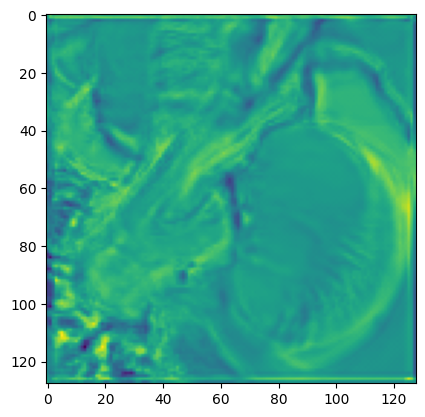

_______________ Iteration: 0 ______________
torch.Size([2, 512, 16, 16, 16])
torch.Size([2, 512, 16, 16, 16])

torch.Size([2, 256, 32, 32, 32])
torch.Size([2, 256, 32, 32, 32])

torch.Size([2, 128, 64, 64, 64])
torch.Size([2, 128, 64, 64, 64])

torch.Size([2, 64, 128, 128, 128])
torch.Size([2, 64, 128, 128, 128])
Loss: -0.4335


In [ ]:
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image

trainDataset = CustomDataset()

#Training
nEpoch = 1
learningRate = 0.0001
batchSize = 2
model = UNet(n_class=1).to(device) #number of classes: 2 = background and hippocampus
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
c = DiceLoss()
trainDataLoader = torch.utils.data.DataLoader(trainDataset,
                                              batch_size=batchSize,
                                              shuffle=True,
                                              )
iter = 0
print('______________________________________________')
print('Started Training')
for iEpoch in range(nEpoch):
    for xbatch,ybatch in trainDataLoader:
        optimizer.zero_grad() #reset gradients
        output = model(xbatch.to(device))

        loss = c(output, ybatch.to(device))
        print("Loss: " + str(round(loss.item(), 4)))
        loss.backward() #calculate gradients
        optimizer.step() #update weights



        plt.figure()
        image = np.transpose(output.cpu().detach().numpy(), (0, 1, 3, 4, 2))
        image = image[0,0,:,:,43]
        plt.imshow(image)
        plt.show()

        print('_______________ Iteration:', iter,'______________')
        iter+=1

print('______________________________________________')
print('Finished Training')

# New section